In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline

RFM Analysis
============
In this ipynb file, We aim to create columns below
- customer_unique_id: unique key
- recency: days since last purchase
- frequency: number of purchases
- monetary: total amount of purchases
- recency_cluster
- frequency_cluster
- monetary_cluster
- overall_score: sum or product of recency_cluster, frequency_cluster, monetary_cluster

Used clustering algorithm
- KMeans

In [94]:
## Use 4 necessary datasets
df_customers = pd.read_csv('datasets/olist_customers_dataset.csv')
# df_geolocation = pd.read_csv('datasets/olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('datasets/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('datasets/olist_order_payments_dataset.csv')
# df_order_reviews = pd.read_csv('datasets/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('datasets/olist_orders_dataset.csv')
# df_products = pd.read_csv('datasets/olist_products_dataset.csv')
# df_sellers = pd.read_csv('datasets/olist_sellers_dataset.csv')
# df_product_category_name = pd.read_csv('datasets/product_category_name_translation.csv')

In [95]:
## Merge datasets
df1 = df_order_payments.merge(df_order_items, on='order_id')
df2 = df1.merge(df_orders, on='order_id')
df = df2.merge(df_customers, on='customer_id') ## Memo: 'customer_id' is foreign key, not unique

print(df.shape)
df.head()

(117601, 22)


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,...,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,...,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP


In [96]:
## datatypes for each column
df.dtypes

## some data objects should be converted to datetime

order_id                          object
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
dtype: object

In [97]:
## Convert data object to datetime
df_columns = [
  'shipping_limit_date',
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date'
]

for col in df_columns:
  df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

## Feature Engineering
Create new features from the original dataset

In [98]:
## order purchase year, month, day, hour
# df['order_purchase_year'] = df['order_purchase_timestamp'].dt.year
# df['order_purchase_month'] = df['order_purchase_timestamp'].dt.month
# df['order_purchase_day'] = df['order_purchase_timestamp'].dt.day ## We can delete this column because we have day_of_week
# df['order_purchase_hour'] = df['order_purchase_timestamp'].dt.hour

## order purchase dayofweek
# df['order_purchase_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek. \
#     map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

# df['delivery_ahead_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

## Todo: add more features


## Recency

In [99]:
## We use df_rfm for Recency, Frequency, Monetary
df_rfm = pd.DataFrame(df['customer_unique_id'])
df_rfm.columns = ['customer_unique_id']

## Get the latest purchase date for each customer
df_latest_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
df_latest_purchase.columns = ['customer_unique_id', 'latest_purchase_date']
## Get Recency
df_latest_purchase['recency'] = (
    df_latest_purchase['latest_purchase_date'].max() - df_latest_purchase['latest_purchase_date']
).dt.days

## Merge Recency to df_rfm
df_rfm = df_rfm.merge(df_latest_purchase, on='customer_unique_id')

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency
0,708ab75d2a007f0564aedd11139c7708,2018-04-25 22:01:49,130
1,a8b9d3a27068454b1c98cc67d4e31e6f,2018-06-26 11:01:38,68
2,6f70c0b2f7552832ba46eb57b1c5651e,2017-12-12 11:19:55,264
3,87695ed086ebd36f20404c82d20fca87,2017-12-06 12:04:06,270
4,4291db0da71914754618cd789aebcd56,2018-08-01 08:29:38,33


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_70214/2131498726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency["clusters"] = kmeans.labels_
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders

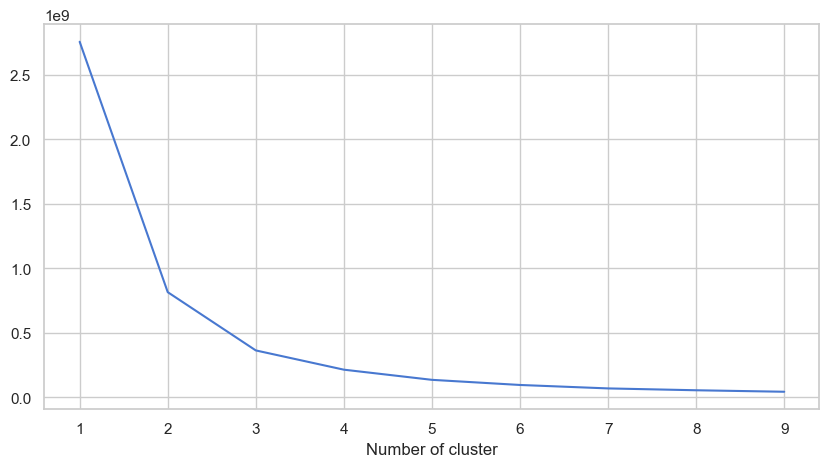

In [100]:
## Use k-means to get recency_cluster
## First of all, we need to know the optimal number of clusters
sse={}
df_recency = df_rfm[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [101]:
## The plot shows that the optimal number is 4 or 5. We choose 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm[['recency']])
df_rfm['recency_cluster'] = kmeans.predict(df_rfm[['recency']])

# recency_cluster's number is not meaningful, we need to change it to meaningful number
def order_cluster(cluster_column_name, target_column_name, df, ascending=False):
    df_tmp = df.groupby(cluster_column_name)[target_column_name].mean().reset_index()
    df_tmp = df_tmp.sort_values(by=target_column_name, ascending=ascending).reset_index(drop=True)
    df_tmp['index'] = df_tmp.index + 1 ## plus 1 because we don't want to start from 0. We may multiply 3 clusters for overall score

    df_output = pd.merge(
        df,
        df_tmp[[cluster_column_name, 'index']],
        on=cluster_column_name
    )
    df_output = df_output.drop([cluster_column_name], axis=1)
    df_output = df_output.rename(columns = {"index": cluster_column_name})
    return df_output

df_rfm = order_cluster('recency_cluster', 'recency', df_rfm)

df_rfm.groupby('recency_cluster')['recency'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
1,20780.0,489.862416,59.406764,405.0,443.0,481.0,532.0,728.0
2,30981.0,319.339434,43.689623,254.0,281.0,313.0,356.0,404.0
3,33909.0,187.833348,35.028997,128.0,158.0,187.0,218.0,253.0
4,31931.0,66.785224,36.031613,0.0,33.0,67.0,100.5,127.0


In [102]:
## The count and mean values show the recency_cluster is meaningful


## Frequency

In [103]:
df_frequency = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
df_frequency.columns = ['customer_unique_id', 'frequency']

## Merge Frequency to df_rfm
df_rfm = df_rfm.merge(df_frequency, on='customer_unique_id')

df_rfm['frequency'].describe()

count    117601.000000
mean          1.083732
std           0.392386
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          16.000000
Name: frequency, dtype: float64

In [104]:
## The table above shows that most customers ordered only once.

# count the number that frequency is more than 1
repeater_nu = df_rfm[df_rfm['frequency'] > 1].shape[0]
repeater_ratio = repeater_nu / df_rfm.shape[0]
print('The number of repeater:', repeater_nu)
print('The ratio of repeater:', repeater_ratio)

The number of repeater: 7931
The ratio of repeater: 0.06743990272191563


In [105]:
## Create 2 clusters, ordered more than once(2)? or only once(1)?
df_rfm['frequency_cluster'] = np.where(df_rfm['frequency'] > 1, 2, 1)
df_rfm.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
1,109670.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,7931.0,2.241584,0.919532,2.0,2.0,2.0,2.0,16.0


## Monetary

In [106]:
df_monetary = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()

df_rfm = df_rfm.merge(df_monetary, on='customer_unique_id')

df_monetary.describe()

,payment_value
count,95419.000000
mean,212.831142
std,641.763082
min,9.590000
25%,63.910000
50%,113.150000
75%,202.545000
max,109312.640000


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_70214/1291469255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue["clusters"] = kmeans.labels_
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders

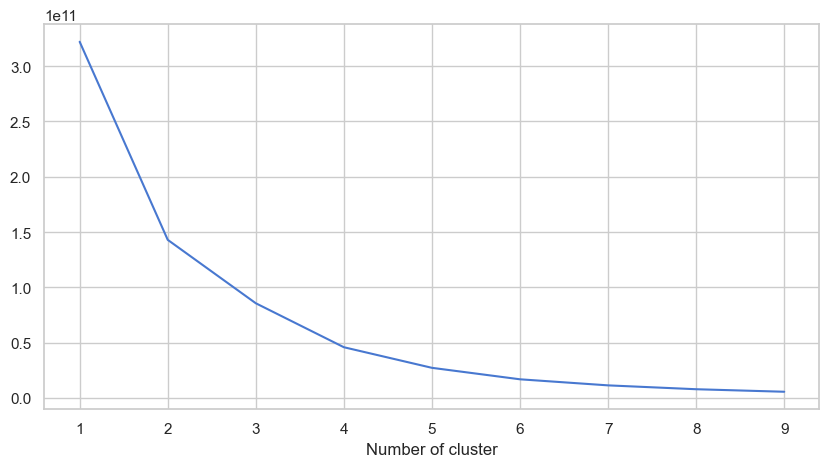

In [107]:
## Use k-means
sse={}
df_revenue = df_rfm[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [108]:
## The plot shows that the optimal number is 4, 5, or 6. We choose 5.
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['payment_value']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['payment_value']])


#order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'payment_value', df_rfm)

#show details of the dataframe
df_rfm.groupby('monetary_cluster')['payment_value'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
1,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.64,109312.64
2,46.0,43587.292174,2837.177072,36489.24,44048.00,44048.00,45256.00,45256.00
3,184.0,20278.110435,5207.417793,14196.28,16313.60,19174.38,25051.89,30186.00
4,715.0,7281.274490,2173.817963,4663.44,5526.54,6716.48,8511.75,12834.50
5,5291.0,1985.695874,850.612035,1093.50,1333.80,1689.84,2356.00,4629.75
6,111357.0,196.720766,199.273241,9.59,67.83,125.14,236.88,1092.74


In [109]:
## Most cusotmers in the cluster 5.
## So I use log transformation, and recreate the clusters.

## Remove monetary_cluster column
df_rfm = df_rfm.drop('monetary_cluster', axis=1)

# Apply log transformation
df_rfm['monetary_log'] = np.log(df_rfm['payment_value'])

# Run K-means on the transformed data
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['monetary_log']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['monetary_log']])

# Order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'monetary_log', df_rfm, True)

# Show details of the dataframe
df_rfm.groupby('monetary_cluster')['monetary_log'].describe()


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
1,19635.0,3.646783,0.267290,2.260721,3.485232,3.691127,3.861361,4.014760
2,30783.0,4.380099,0.202107,4.015121,4.207078,4.377265,4.557240,4.722864
3,32245.0,5.062066,0.203377,4.722953,4.890950,5.057073,5.234099,5.439556
4,20005.0,5.816220,0.238279,5.439643,5.608886,5.792465,6.016450,6.279665
5,11480.0,6.748866,0.325315,6.279946,6.473181,6.692902,6.987003,7.473495
6,3453.0,8.211525,0.716137,7.474721,7.661734,7.992961,8.533130,11.601967


## Overall Score
We can create two types of overall score
1. Sum of recency, frequency, and monetary
2. Product of recency, frequency, and monetary

### 1. Overall Score (sum)

In [110]:
## Now, we have recency_cluster, and monetary_cluster. Let's get the overall RFM Score.
df_rfm['overall_score_sum'] = df_rfm['recency_cluster'] + df_rfm['frequency_cluster'] + df_rfm['monetary_cluster']

In [111]:
df_rfm.groupby('overall_score_sum')[['recency', 'frequency', 'monetary_log']].mean()

,recency,frequency,monetary_log
overall_score_sum,,,
3,491.639978,1.000000,3.645457
4,406.886087,1.001903,4.033014
5,329.502265,1.010246,4.345430
6,244.643821,1.021481,4.617370
7,202.320349,1.050142,5.111762
8,166.024078,1.105613,5.631461
9,143.693033,1.216753,6.279032
10,104.167500,1.380625,6.880321
11,86.663361,1.922404,7.639305


In [112]:
df_rfm.groupby('overall_score_sum')['overall_score_sum'].count()

overall_score_sum
3      3622
4     10508
5     19422
6     24906
7     24311
8     18066
9     10076
10     4800
11     1714
12      176
Name: overall_score_sum, dtype: int64

In [113]:
## Segment customers based on their overall_score_sum
## We can change the threshold values
df_rfm['segment_sum'] = 'Low-Value'
df_rfm.loc[df_rfm['overall_score_sum'] > 7,'segment_sum'] = 'Mid-Value'
df_rfm.loc[df_rfm['overall_score_sum'] > 9,'segment_sum'] = 'High-Value'

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency,recency_cluster,frequency,frequency_cluster,payment_value,monetary_log,monetary_cluster,overall_score_sum,segment_sum
0,708ab75d2a007f0564aedd11139c7708,2018-04-25 22:01:49,130,3,1,1,99.33,4.598448,2,6,Low-Value
1,bd5fb6a2e66d7bfb061efd93b994f168,2018-01-29 19:54:35,216,3,1,1,67.50,4.212128,2,6,Low-Value
2,1504b719eb728716ff7583dc7b86a0b0,2018-04-19 09:55:30,136,3,1,1,64.03,4.159352,2,6,Low-Value
3,47a0a92a1b4d507faa45c6d4910e9d2d,2018-02-26 09:55:52,188,3,1,1,68.49,4.226688,2,6,Low-Value
4,f42a3583d172ef020244c94136cac8db,2018-02-01 07:44:28,214,3,1,1,90.05,4.500365,2,6,Low-Value


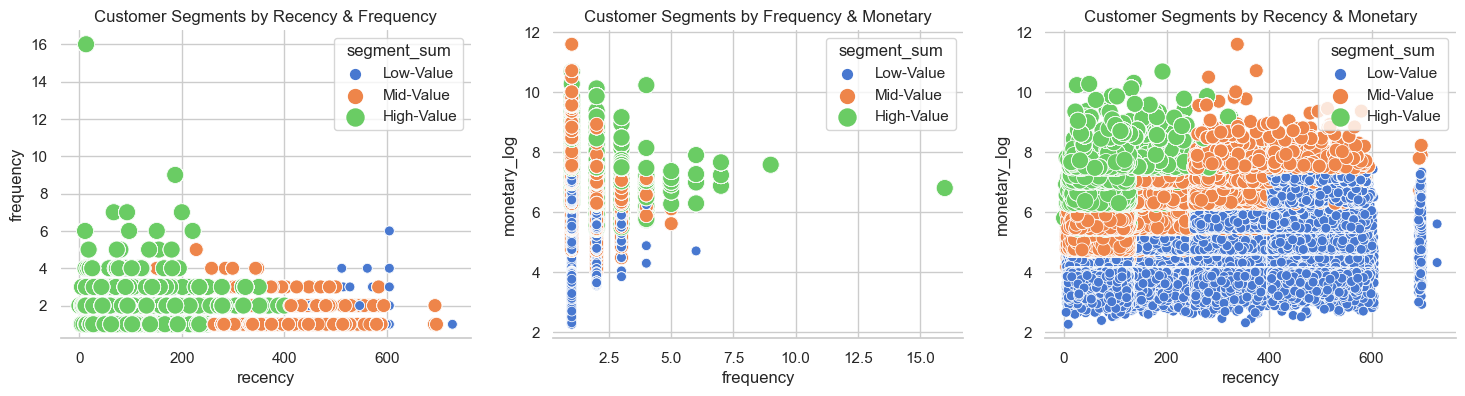

In [114]:
## Visualization: Customer Semgments, using 'egment_sum' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='segment_sum', data=df_rfm, size='segment_sum', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='segment_sum', data=df_rfm, size='segment_sum' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='segment_sum', data=df_rfm, size='segment_sum' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

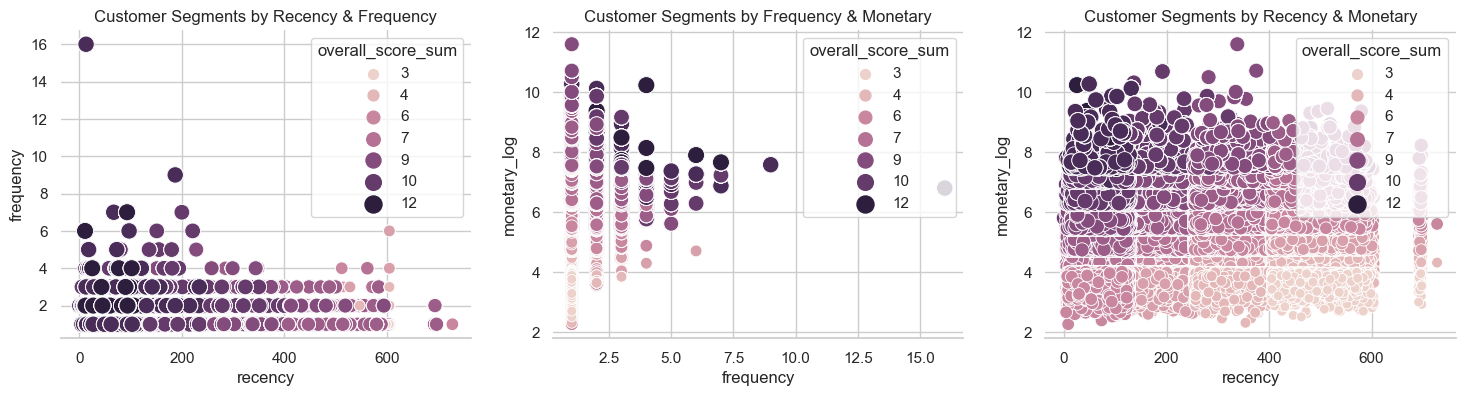

In [115]:
## Visualization: Customer Semgments, using 'overall_score_sum' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='overall_score_sum', data=df_rfm, size='overall_score_sum', sizes=(50,150))
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='overall_score_sum', data=df_rfm, size='overall_score_sum' , sizes=(50,150))
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='overall_score_sum', data=df_rfm, size='overall_score_sum' , sizes=(50,150))
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

### Overall Score (product)

In [116]:
df_rfm['overall_score_product'] = df_rfm['recency_cluster'] * df_rfm['frequency_cluster'] * df_rfm['monetary_cluster']

df_rfm.groupby('overall_score_product')[['recency', 'frequency', 'monetary_log']].mean()

,recency,frequency,monetary_log
overall_score_product,,,
1,491.639978,1.000000,3.645457
2,406.886087,1.001903,4.033014
3,333.884378,1.000000,4.325128
4,273.749803,1.012038,4.409971
5,498.301082,1.000000,6.736478
6,261.055487,1.020268,4.799189
8,171.252393,1.042279,4.941146
9,187.831813,1.000000,5.063986
10,333.818373,1.094320,6.746648


In [117]:
df_rfm.groupby('overall_score_product')['overall_score_product'].count()

overall_score_product
1      3622
2     10508
3     11157
4     16531
5      1664
6     16923
8     13269
9      8770
10     2852
12    14861
15     2740
16     5452
18     1473
20     3125
24     2321
30      449
32      811
36      247
40      650
48      176
Name: overall_score_product, dtype: int64

In [118]:
## Segment customers based on their overall_score_product
## We can change the threshold values
df_rfm['segment_product'] = 'Low-Value'
df_rfm.loc[df_rfm['overall_score_product'] > 10, 'segment_score'] = 'Mid-Value'
df_rfm.loc[df_rfm['overall_score_product'] > 24,'segment_score'] = 'High-Value'

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency,recency_cluster,frequency,frequency_cluster,payment_value,monetary_log,monetary_cluster,overall_score_sum,segment_sum,overall_score_product,segment_product,segment_score
0,708ab75d2a007f0564aedd11139c7708,2018-04-25 22:01:49,130,3,1,1,99.33,4.598448,2,6,Low-Value,6,Low-Value,NaN
1,bd5fb6a2e66d7bfb061efd93b994f168,2018-01-29 19:54:35,216,3,1,1,67.50,4.212128,2,6,Low-Value,6,Low-Value,NaN
2,1504b719eb728716ff7583dc7b86a0b0,2018-04-19 09:55:30,136,3,1,1,64.03,4.159352,2,6,Low-Value,6,Low-Value,NaN
3,47a0a92a1b4d507faa45c6d4910e9d2d,2018-02-26 09:55:52,188,3,1,1,68.49,4.226688,2,6,Low-Value,6,Low-Value,NaN
4,f42a3583d172ef020244c94136cac8db,2018-02-01 07:44:28,214,3,1,1,90.05,4.500365,2,6,Low-Value,6,Low-Value,NaN


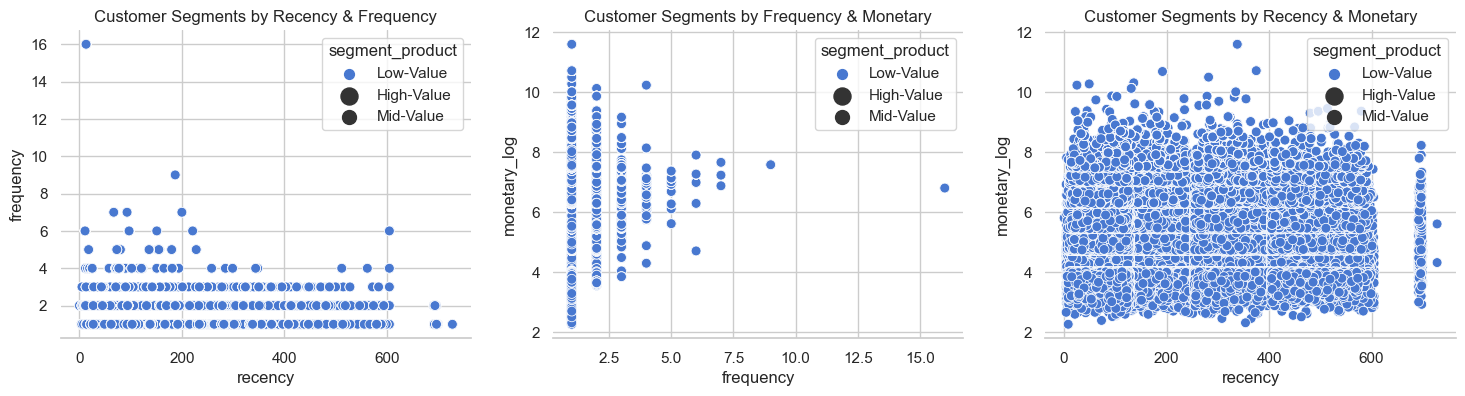

In [119]:
## Visualization: Customer Semgments, using 'segment_product' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='segment_product', data=df_rfm, size='segment_product', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='segment_product', data=df_rfm, size='segment_product' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='segment_product', data=df_rfm, size='segment_product' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

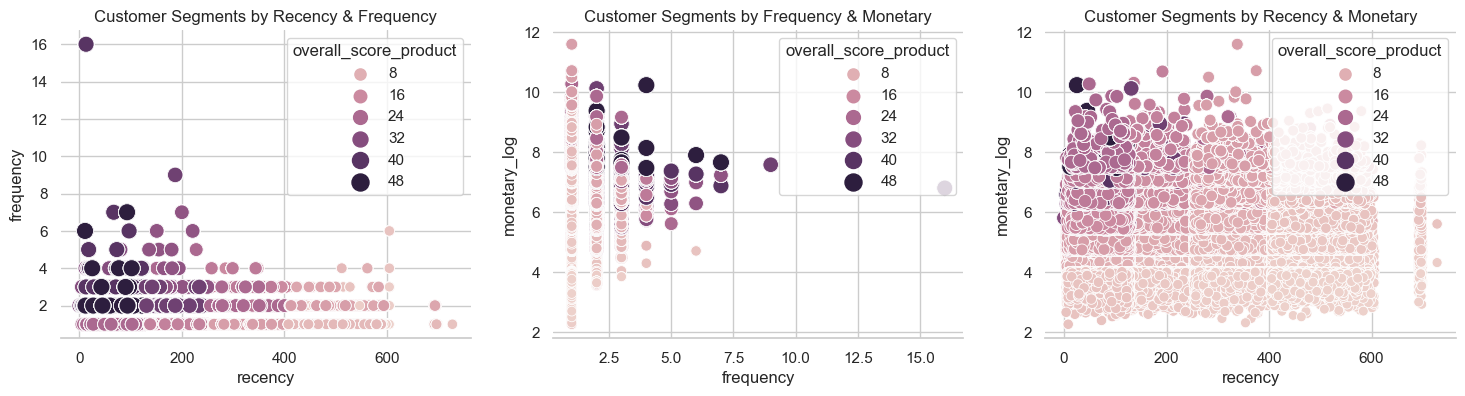

In [120]:
## Visualization: Customer Semgments, using 'overall_score_product' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='overall_score_product', data=df_rfm, size='overall_score_product', sizes=(50,150))
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='overall_score_product', data=df_rfm, size='overall_score_product' , sizes=(50,150))
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='overall_score_product', data=df_rfm, size='overall_score_product' , sizes=(50,150))
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

### TODO (optional)
We can calculate overall score by weighting each feature differently.
For example, we can give more weight to recency than frequency and monetary.